<h1><center>Clustering on Vehicle dataset</center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>    
                <li><a href="#data_cleaning">Data Cleaning</a></li>
                <li><a href="#clustering_using_scipy">Clustering Using Scipy</a></li>
                <li><a href="#clustering_using_skl">Clustering using scikit-learn</a></li>
            </ol>
    </ol>
</div>
<br>
<hr>

An automobile manufacturer has developed prototypes for a new vehicle. 
Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes--that is, how vehicles can be grouped, which group is the most similar with the model, and therefore which models they will be competing against.

Our objective here, is to use clustering methods, to find the most distinctive clusters of vehicles. It will summarize the existing vehicles and help manufacturers to make decision about the supply of new models.

<h2 id="importing_libraries">Importing required libraries</h2>

In [1]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('dark_background')
print('Libraries imported.')

Libraries imported.


### Download data 

In [2]:
pdf = pd.read_csv('cars_clus.csv')

## Read data
Lets read dataset to see what features the manufacturer has collected about the existing models.

In [3]:
pdf.head(5)

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


The feature sets include  price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).

<h2 id="data_cleaning">Data Cleaning</h2>
lets simply clear the dataset by dropping the rows that have null value:

In [4]:
print ("Shape of dataset before cleaning: ", pdf.size)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Shape of dataset after cleaning: ", pdf.size)
pdf.head(5)

Shape of dataset before cleaning:  2544
Shape of dataset after cleaning:  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


### Feature selection
Lets select our feature set:

In [5]:
featureset = pdf[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

### Normalization
Now we can normalize the feature set. __MinMaxScaler__ transforms features by scaling each feature to a given range. It is by default (0, 1). That is, this estimator scales and translates each feature individually such that it is between zero and one.

In [6]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

<h2 id="clustering_using_scipy">Clustering using Scipy</h2>
In this part we use Scipy package to cluster the dataset:  
First, we calculate the distance matrix. 

In [7]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. 
The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
    - single
    - complete
    - average
    - weighted
    - centroid
    
    
We use __complete__ for our case, but feel free to change it to see how the results change.

In [8]:
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

Essentially, Hierarchical clustering does not require a pre-specified number of clusters. However, in some applications we want a partition of disjoint clusters just as in flat clustering.
So you can use a cutting line:

In [9]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 1,  5,  5,  6,  5,  4,  6,  5,  5,  5,  5,  5,  4,  4,  5,  1,  6,
        5,  5,  5,  4,  2, 11,  6,  6,  5,  6,  5,  1,  6,  6, 10,  9,  8,
        9,  3,  5,  1,  7,  6,  5,  3,  5,  3,  8,  7,  9,  2,  6,  6,  5,
        4,  2,  1,  6,  5,  2,  7,  5,  5,  5,  4,  4,  3,  2,  6,  6,  5,
        7,  4,  7,  6,  6,  5,  3,  5,  5,  6,  5,  4,  4,  1,  6,  5,  5,
        5,  6,  4,  5,  4,  1,  6,  5,  6,  6,  5,  5,  5,  7,  7,  7,  2,
        2,  1,  2,  6,  5,  1,  1,  1,  7,  8,  1,  1,  6,  1,  1],
      dtype=int32)

Also, you can determine the number of clusters directly:

In [10]:
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters


array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

Now, plot the dendrogram:

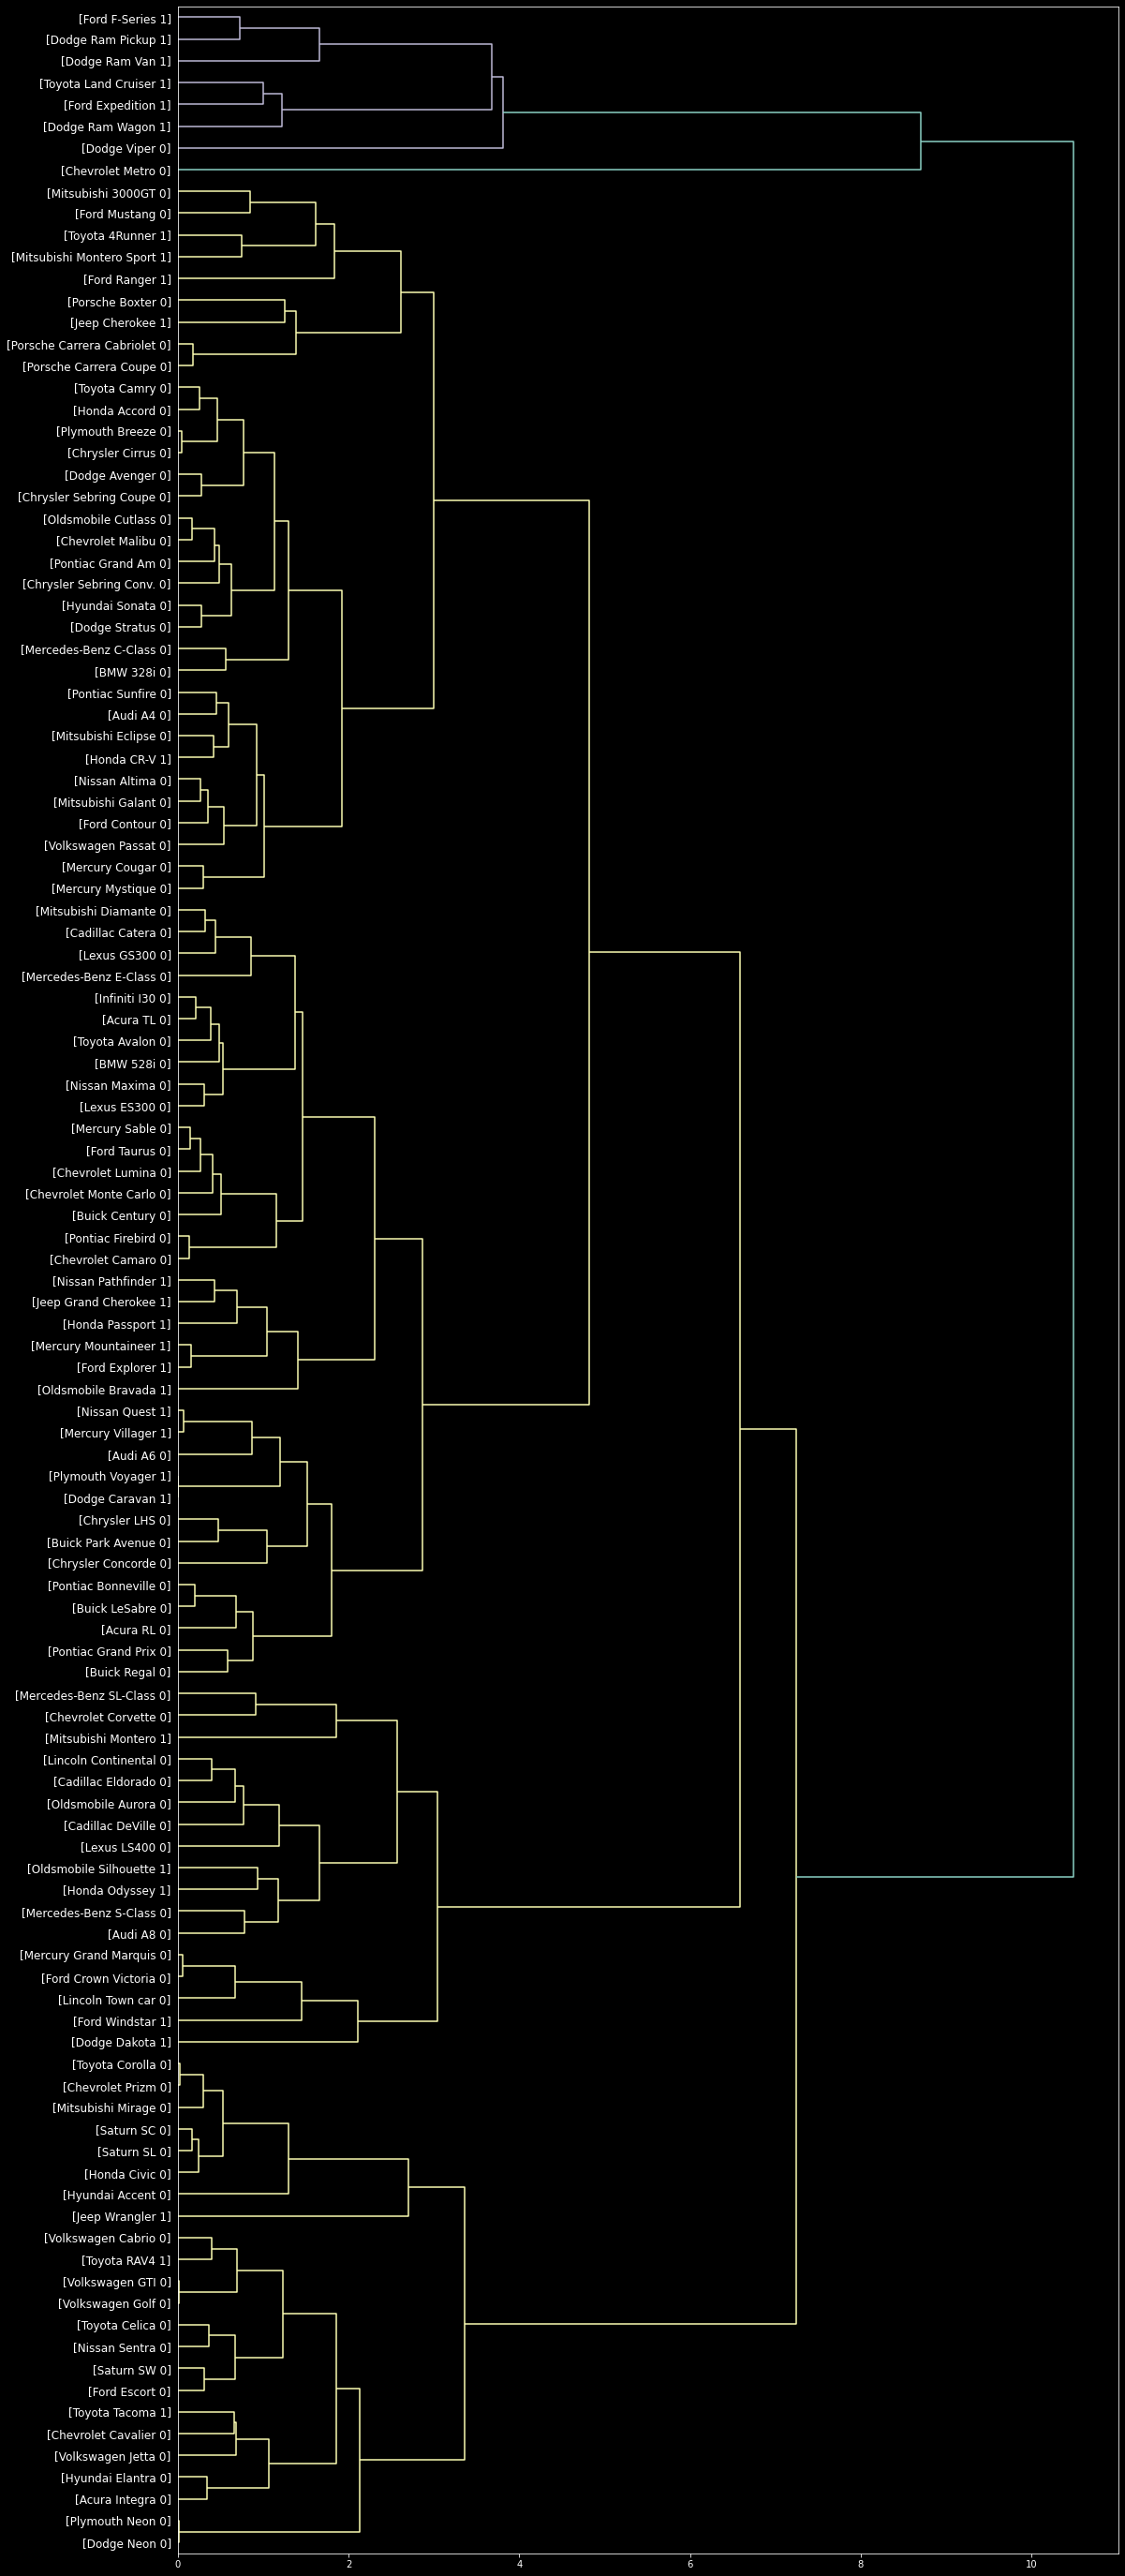

In [11]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

<h2 id="clustering_using_skl">Clustering using scikit-learn</h2>
Lets redo it again, but this time using scikit-learn package:

In [12]:
dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.57777143 0.75455727 ... 0.28530295 0.24917241 0.18879995]
 [0.57777143 0.         0.22798938 ... 0.36087756 0.66346677 0.62201282]
 [0.75455727 0.22798938 0.         ... 0.51727787 0.81786095 0.77930119]
 ...
 [0.28530295 0.36087756 0.51727787 ... 0.         0.41797928 0.35720492]
 [0.24917241 0.66346677 0.81786095 ... 0.41797928 0.         0.15212198]
 [0.18879995 0.62201282 0.77930119 ... 0.35720492 0.15212198 0.        ]]


Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

In [13]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1])

And, we can add a new field to our dataframe to show the cluster of each row:

In [14]:
pdf['cluster_'] = agglom.labels_
pdf.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,2
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,1
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

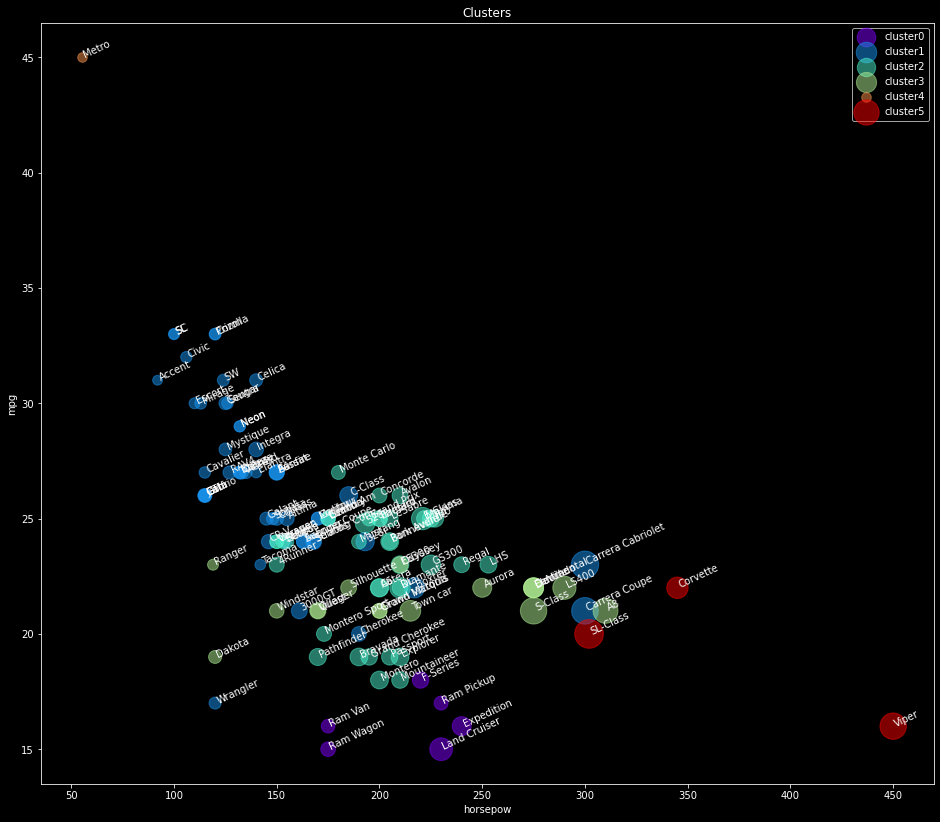

In [15]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

As you can see, we are seeing the distribution of each cluster using the scatter plot, but it is not very clear where is the centroid of each cluster. Moreover, there are 2 types of vehicles in our dataset, "truck" (value of 1 in the type column) and "car" (value of 1 in the type column). So, we use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:

In [16]:
pdf.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: cluster_, dtype: int64

Now we can look at the characteristics of each cluster:

In [17]:
agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

horsepow  engine_s        mpg      price
cluster_ type                                            
0        1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   146.531915  2.246809  27.021277  20.306128
         1.0   145.000000  2.580000  22.200000  17.009200
2        0.0   203.111111  3.303704  24.214815  27.750593
         1.0   182.090909  3.345455  20.181818  26.265364
3        0.0   256.500000  4.410000  21.500000  42.870400
         1.0   160.571429  3.071429  21.428571  21.527714
4        0.0    55.000000  1.000000  45.000000   9.235000
5        0.0   365.666667  6.233333  19.333333  66.010000


It is obvious that we have 3 main clusters with the majority of vehicles in those.

__Cars__:
- Cluster 1: with almost high mpg, and low in horsepower.
- Cluster 2: with good mpg and horsepower, but higher price than average.
- Cluster 3: with low mpg, high horsepower, highest price.
    
    
    
__Trucks__:
- Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
- Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
- Cluster 3: with good mpg and horsepower, low price.


Please notice that we did not use __type__ , and __price__ of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite high accuracy.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

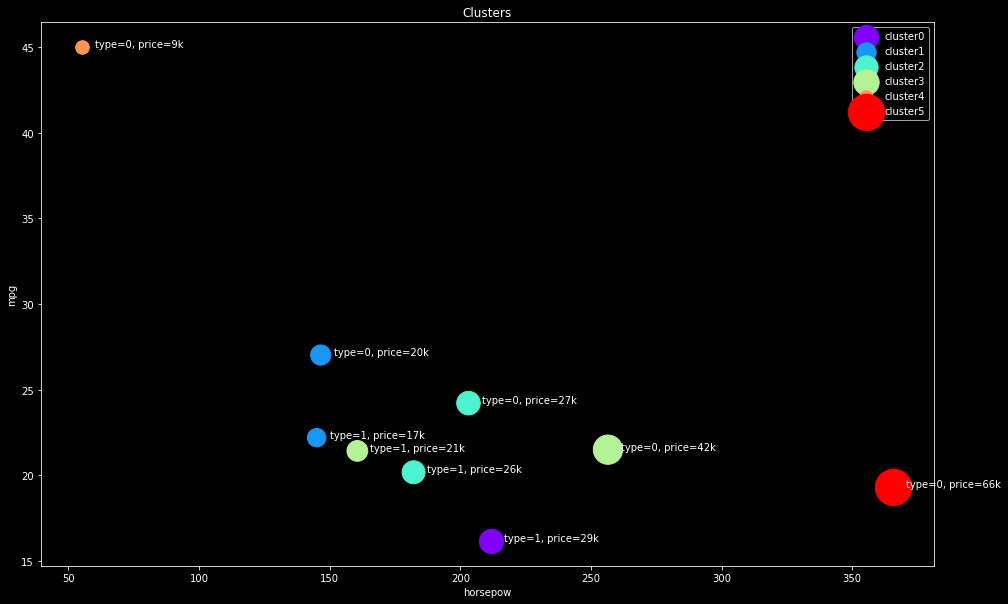

In [18]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')
